## Install OpenCV

In [1]:
# If New Session Uncomment Line Below and Run
# Once OpenCV Installed Re-Comment Line Below and Restart Kernel & Clear Output
# --------------------------------------------------
# ! pip install opencv-python

## Imports

In [2]:
# Python Modules
# --------------------------------------------------
import os
import sys
import numpy             as np 
import pandas            as pd 
import matplotlib.pyplot as plt


# Custom Modules
# --------------------------------------------------
PATH = os.path.abspath(os.path.join(".."))

if PATH not in sys.path:
    sys.path.append(PATH)
    
import config
import utils

Using TensorFlow backend.


## Load X-ray Data

In [3]:
all_xray_df = pd.read_csv(config.ALL_XRAY_PATH)
all_xray_df = utils.add_image_path(all_xray_df)
all_xray_df = utils.add_disease_ind(all_xray_df)

all_xray_df[config.DV] = all_xray_df[config.TARGET_DISEASE].astype(str)

## Split Data

In [4]:
_, valid_data = utils.data_split(all_xray_df)

Removing Train Patient IDs from Valid
Cases Removed: 1177

Train Data Image Count:   2290
Train Data Patient Count: 1770
Train Data Positive:      0.5
Train Data Negative:      0.5

Validation Data Image Count:   740
Validation Data Patient Count: 713
Validation Data Positive:      0.2
Validation Data Negative:      0.8



## Get Data Generator

In [13]:
valid_gen = utils.data_gen(
    data       = valid_data,   
    split      = "valid",   
    batch_size = valid_data.shape[0],
    image_size = config.IMG_SIZE
)

val_x, val_y = valid_gen.next()

Found 740 validated image filenames belonging to 2 classes.


## Load and Predict with Models

In [14]:
vgg16_models    = {a_model : None for a_model in list(config.VGG16_ARCHITECTURES)}
vgg16_histories = {a_model : None for a_model in list(config.VGG16_ARCHITECTURES)}
vgg16_preds     = {a_model : []   for a_model in list(config.VGG16_ARCHITECTURES)}

for a_model in vgg16_models:
    
    # Load Models
    # --------------------------------------------------
    print(
        f"--------------------------------------------------\n"
        f"Loading    {a_model}"
    )
    
    vgg16_models[a_model], vgg16_histories[a_model] = utils.load_model(
        model_name    = f"{config.MODEL_PATH}/vgg16/{a_model}{config.MODEL_EXT}",
        model_weights = f"{config.WEIGHT_PATH}/vgg16/{a_model}{config.WEIGHT_EXT}",
        model_history = f"{config.HISTORY_PATH}/vgg16/{a_model}{config.HISTORY_EXT}"
    )
    
    
    # Predict with Models
    # --------------------------------------------------
    print(f"Predicting {a_model}")
    
    vgg16_preds[a_model] = utils.predict_with_model(vgg16_models[a_model], val_x)

--------------------------------------------------
Loading    model_1
Predicting model_1
740/740 [==============================] - 8s 11ms/step
--------------------------------------------------
Loading    model_2
Predicting model_2
740/740 [==============================] - 7s 9ms/step
--------------------------------------------------
Loading    model_3
Predicting model_3
740/740 [==============================] - 7s 9ms/step


## AUC

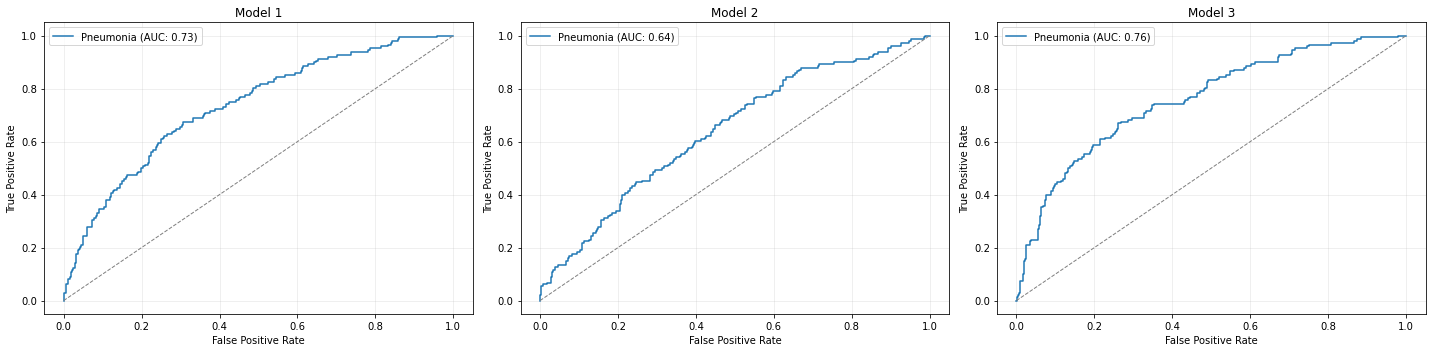

In [15]:
utils.plot_model_auc(
    pred = vgg16_preds, 
    true = val_y
)

## Precision-Recall Curve

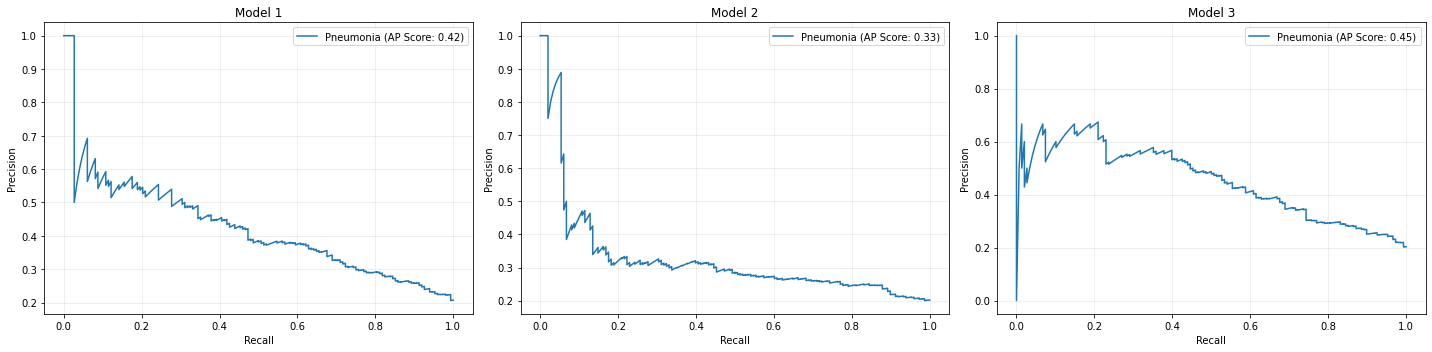

In [16]:
utils.plot_model_prc(
    pred = vgg16_preds, 
    true = val_y
)

Model 1 appears to have a higher precision, thus exhibiting a tendency to favor a low false positive (FP) rate, which is beneficial with regard to diagnosing Pneumonia. We would not want to falsely diagnose a patient as NOT having Pneumonia (FN) when they do have Pneumonia. The downside of this higher precision is that there will be more cases that will be diagnosed as having Pneumonia when no Pneumonia is present. Of course, the algorithm can be utilized as a screening process so a radiologist giving the official diagnosis can have less negative cases to review, thus possibly reducing radiologist burnout. 

## F1-Score

Model 1
--------------------------------------------------
Threshold: 0.41

Precision: 0.38
Recall:    0.62
F1-Score:  0.47


Model 2
--------------------------------------------------
Threshold: 0.34

Precision: 0.26
Recall:    0.77
F1-Score:  0.39


Model 3
--------------------------------------------------
Threshold: 0.49

Precision: 0.47
Recall:    0.53
F1-Score:  0.5




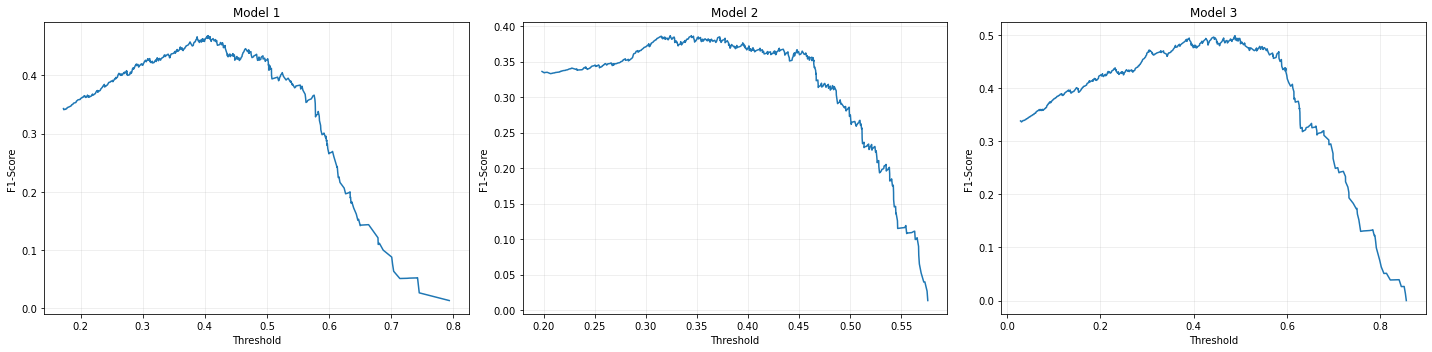

In [17]:
vgg16_thresh = utils.plot_model_f1_threshold(
    pred = vgg16_preds, 
    true = val_y
)

The F1-Score is the metric to be used for selecting the ideal model. Based on the above, Model 1 appears to be the ideal model with an F1-Score of 0.47 around a threshold of 0.38.

## Model History

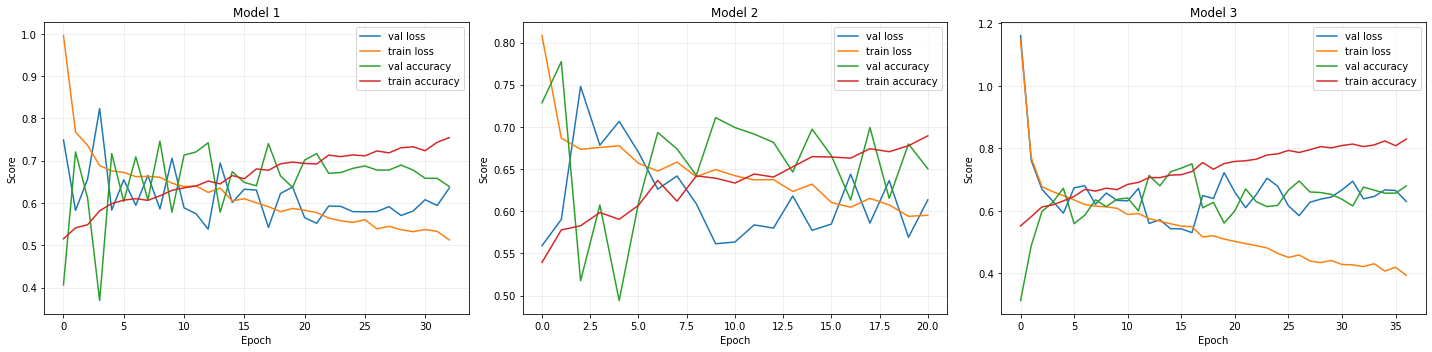

In [18]:
utils.plot_model_history(vgg16_histories)

Approximately around epoch 22 Model 1 began to overfit the data. That is, the validation loss plateaued in its decrease while the training loss continued to decrease.

## Error Analysis 

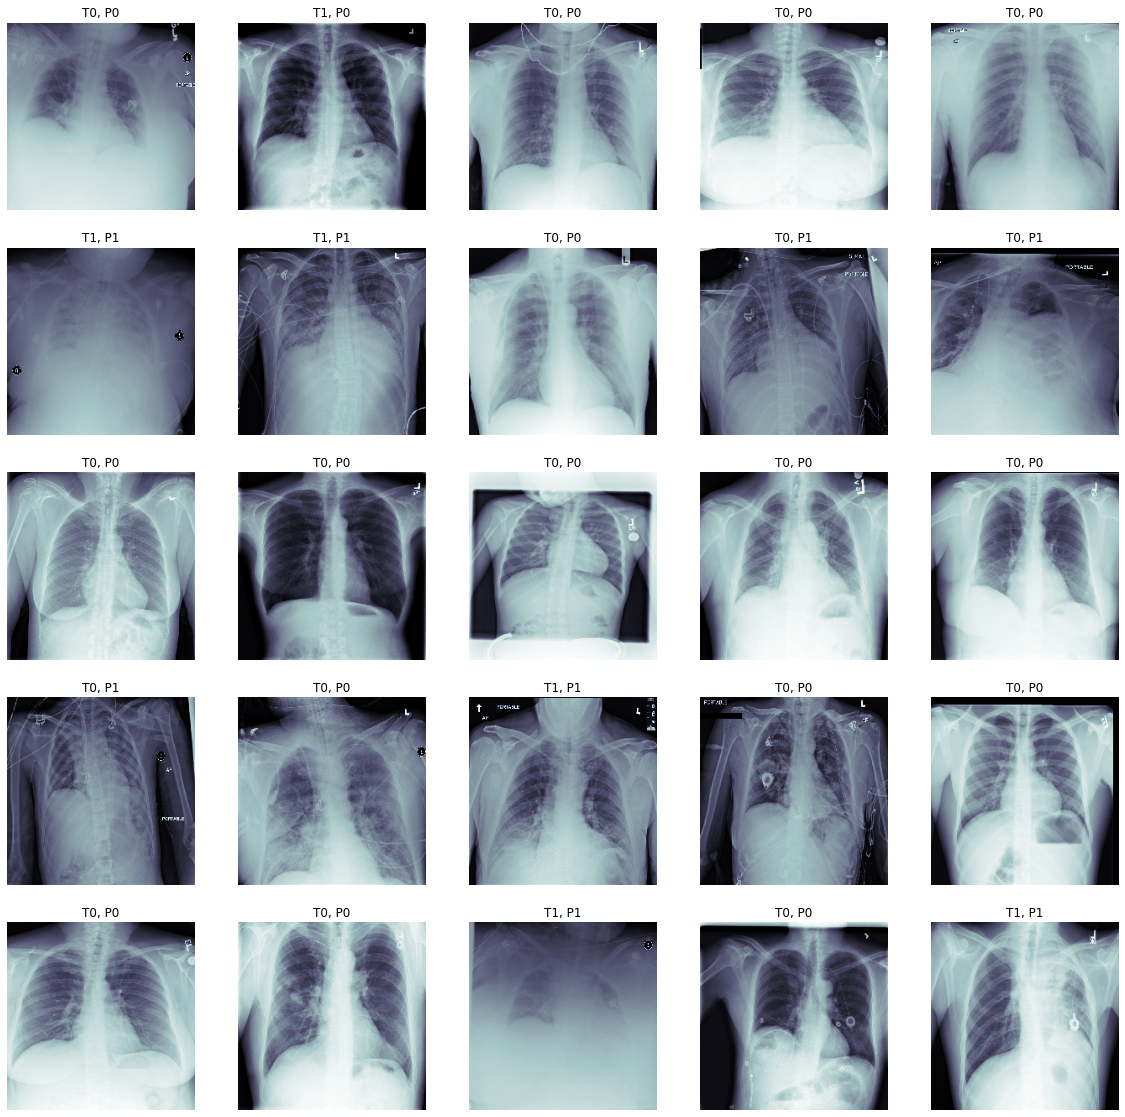

In [19]:
utils.plot_pred_true_xray_grid(
    x      = val_x, 
    y      = val_y, 
    pred   = vgg16_preds, 
    thresh = vgg16_thresh
)

As suggested above, the selected model (Model 1) favors a higher precision, therefore more prone to false positives (FP). Given the example images above, this statement is supported by more cases being flagged as an FP then FN. From the evaluation of the selected model, it is strongly recommended that the algorithm - if deployed into production - should be used as a screening tool; not as a tool for diagnosis.